In [1]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os

os.sys.path.append("../")

# Implementation of Fast Histo Version 2

In [3]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep

hep.style.use("CMS")
from tqdm import tqdm
from sklearn.cluster import DBSCAN

In [92]:
from statsmodels.stats.proportion import proportion_confint

In [4]:
from statsmodels.stats.proportion import proportion_confint

In [259]:
import copy

In [316]:
import pickle

In [5]:
tqdm.pandas()

In [183]:
# storage = '/mnt/storage/lborgna/track/l1_nnt/'
storage = "/Volumes/ExternalSSD/track/l1_nnt/"
tp_original = pd.read_pickle(storage + "tp.pkl")
trk_original = pd.read_pickle(storage + "trk.pkl")
mc_original = pd.read_pickle(storage + "mc.pkl")

In [184]:
tp = tp_original.copy()
trk = trk_original.copy()
mc = mc_original.copy()

In [185]:
tp.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 39363835 entries, (0, 0) to (222975, 213)
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   tp_pt       float32
 1   tp_eta      float32
 2   tp_phi      float32
 3   tp_d0       float32
 4   tp_z0       float32
 5   tp_eventid  int32  
dtypes: float32(5), int32(1)
memory usage: 1.1 GB


# Data Pre-processing

**EDA of missing and infinite values in the dataset**

In [186]:
trk["trk_pt"].isna().value_counts()

False    40780722
Name: trk_pt, dtype: int64

In [187]:
np.isinf(trk["trk_pt"]).value_counts()

False    40780640
True           82
Name: trk_pt, dtype: int64

In [188]:
for feature in trk.columns:
    print(f"-----------------{feature}---------------")
    print("NAN? \n", trk[feature].isna().value_counts())
    print("INF? \n", np.isinf(trk[feature]).value_counts())

-----------------trk_pt---------------
NAN? 
 False    40780722
Name: trk_pt, dtype: int64
INF? 
 False    40780640
True           82
Name: trk_pt, dtype: int64
-----------------trk_eta---------------
NAN? 
 False    40780640
True           82
Name: trk_eta, dtype: int64
INF? 
 False    40780722
Name: trk_eta, dtype: int64
-----------------trk_phi---------------
NAN? 
 False    40780722
Name: trk_phi, dtype: int64
INF? 
 False    40780722
Name: trk_phi, dtype: int64
-----------------trk_d0---------------
NAN? 
 False    40780722
Name: trk_d0, dtype: int64
INF? 
 False    40780722
Name: trk_d0, dtype: int64
-----------------trk_z0---------------
NAN? 
 False    40780722
Name: trk_z0, dtype: int64
INF? 
 False    40780722
Name: trk_z0, dtype: int64
-----------------trk_fake---------------
NAN? 
 False    40780722
Name: trk_fake, dtype: int64
INF? 
 False    40780722
Name: trk_fake, dtype: int64


In [189]:
pd.set_option("display.max_rows", 100)

**Conclusion of inf/nan eda: It seems that there are some cases where there is no $\eta$ information available (NaN) as well as infinite values for the $p_T$. There doesn't seem to be a physical/ logical reason for this at the moment so lets drop these away**

In [190]:
trk.loc[~trk["trk_eta"].isna()]

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake
entry  subentry                                                          
0      0         2.623967  1.301414 -0.289234   999.0 -0.878906         2
       1         3.435026  0.566814 -0.159267   999.0  3.339844         2
       2         3.774908  1.815973 -0.240375   999.0  4.921875         1
       3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2
       4         2.320653  1.837421  0.032604   999.0  4.980469         1
...                   ...       ...       ...     ...       ...       ...
222975 211       2.044568 -2.407456 -0.857553   999.0  1.113281         2
       212       2.491473 -2.141478 -0.616329   999.0  8.847656         2
       213       2.669393  2.230316 -0.748241   999.0 -0.234375         2
       214       3.767222 -1.994298 -0.753691   999.0 -4.746094         2
       215       1.988538 -2.052655 -0.790385   999.0  0.996094         2

[40780640 rows x 6 columns]

In [191]:
def remove_nans(df: pd.DataFrame, feature: str = "trk_eta") -> pd.DataFrame:
    return df.loc[~df[feature].isna()]

In [192]:
trk = remove_nans(trk, feature="trk_eta")

**Create truth labels of primary vertex**

In [193]:
def create_pv_truth_labels(
    df: pd.DataFrame, truth_label: str = "trk_fake", truth_label_out: str = "is_pv"
) -> pd.DataFrame:

    df[truth_label_out] = 0
    df.loc[df[truth_label] == 1, truth_label_out] = 1

    return df

In [194]:
trk = create_pv_truth_labels(trk, truth_label="trk_fake", truth_label_out="is_pv")

In [19]:
trk

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry  subentry                                                             
0      0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
       1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
       2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
       3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
       4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                   ...       ...       ...     ...       ...       ...   
222975 211       2.044568 -2.407456 -0.857553   999.0  1.113281         2   
       212       2.491473 -2.141478 -0.616329   999.0  8.847656         2   
       213       2.669393  2.230316 -0.748241   999.0 -0.234375         2   
       214       3.767222 -1.994298 -0.753691   999.0 -4.746094         2   
       215       1.988538 -2.052655 -0.790385   999.0  0.996094         2   

                 is_pv  
entry  subentry         
0      0             0  
       1             0  
       2             1  
       3             0  
       4             1  
...                ...  
222975 211           0  
       212           0  
       213           0  
       214           0  
       215           0  

[40780640 rows x 7 columns]

# FastHisto Algorithm Development (Single Event)

In [20]:
e1 = trk.query("entry==0").copy()

In [21]:
tp_e1 = tp.query("entry==0").copy()

In [22]:
tp_e1.value_counts()

tp_pt      tp_eta     tp_phi     tp_d0      tp_z0      tp_eventid
2.001049   -2.054922  -0.967860  -0.000764  -0.367673  153           1
3.031496    1.188693   0.379719   0.000038  -1.915808  44            1
2.898700    1.458428  -2.449849  -0.000067  -1.916268  44            1
2.914866    1.954846  -1.833646   0.001749  -1.147969  78            1
2.928734   -1.193379   0.240557   0.000811   2.722564  93            1
                                                                    ..
2.323342    1.872302  -2.434791  -0.000320   3.158887  73            1
2.324431    1.153279  -0.342064   0.000384  -0.957170  180           1
2.335640    2.006726  -1.436634   0.001297   5.206273  170           1
2.340254    1.608032   1.363557  -0.000215  -2.971305  26            1
30.443727  -1.433386   0.742923   0.330537   5.046057  0             1
Length: 152, dtype: int64

**Histogram level comparison**

In [23]:
be = np.linspace(-15, 15, 256)

In [24]:
bw = be[1] - be[0]

(-8.0, 8.0)

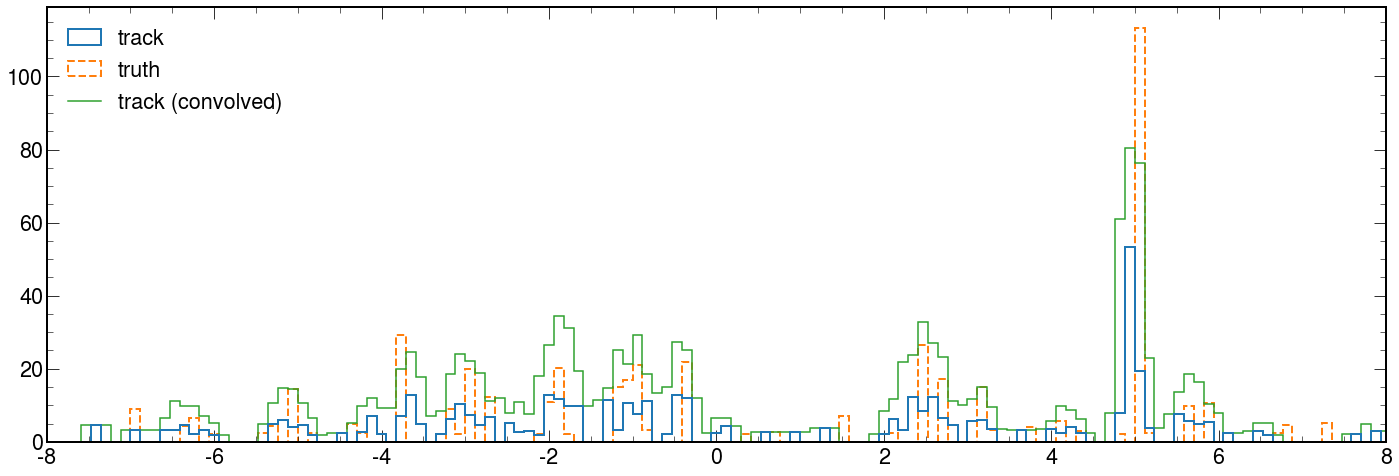

In [25]:
plt.subplots(figsize=(24, 8))
htrk, be, _ = plt.hist(
    e1.trk_z0, bins=be, weights=e1.trk_pt, label="track", histtype="step", lw=2
)
_ = plt.hist(
    tp_e1.tp_z0,
    bins=be,
    weights=tp_e1.tp_pt,
    label="truth",
    histtype="step",
    lw=2,
    ls="--",
    zorder=1,
)
htrk_c = np.convolve(htrk, [1, 1, 1], mode="same")
hep.histplot(htrk_c, be, label="track (convolved)")
plt.legend(loc="upper left")
plt.xlim(-8, 8)

In [26]:
max_index = np.argmax(htrk_c)

In [27]:
max_index

169

In [28]:
type(max_index)

numpy.int64

In [29]:
def z0_fh(bin_edges: np.array, max_index: int) -> float:
    half_bin_width = 0.5 * (bin_edges[1] - bin_edges[0])
    lowest_bin = bin_edges[0]
    highest_bin = bin_edges[-1]
    nbins = bin_edges.shape[0]

    z0 = lowest_bin + (highest_bin - lowest_bin) * (max_index / nbins) + half_bin_width

    return z0

In [30]:
z0_reco = z0_fh(be, max_index=max_index)

In [31]:
z0_reco

4.8635110294117645

In [32]:
e1["z0_reco"] = z0_reco

In [33]:
e1

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry subentry                                                             
0     0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
      1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
      2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
      3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
      4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                  ...       ...       ...     ...       ...       ...   
      154       2.026653 -2.021094 -1.062191   999.0 -0.410156         2   
      155       2.049097 -2.055119 -0.964472   999.0 -0.410156         2   
      156       2.222179 -2.426809 -0.693084   999.0  5.566406         2   
      157       2.563973  2.081842 -0.530004   999.0 -3.046875         2   
      158       2.303798  1.335547 -0.274176   999.0  4.804688         2   

                is_pv   z0_reco  
entry subentry                   
0     0             0  4.863511  
      1             0  4.863511  
      2             1  4.863511  
      3             0  4.863511  
      4             1  4.863511  
...               ...       ...  
      154           0  4.863511  
      155           0  4.863511  
      156           0  4.863511  
      157           0  4.863511  
      158           0  4.863511  

[159 rows x 8 columns]

In [34]:
np.abs(tp_e1.loc[tp_e1["tp_eventid"] == 0]["tp_eta"]).mean()

0.66709495

In [35]:
eta_bins = np.array([0.0, 0.7, 1.0, 1.2, 1.6, 2.0, 2.4])
deltaz_bins = np.array([0.0, 0.4, 0.6, 0.76, 1.0, 1.7, 2.2, 0.0])

In [36]:
e1["resolution"] = np.abs(e1["trk_z0"] - e1["z0_reco"])

In [37]:
def fh_associate(resolution: np.array, eta: np.array) -> np.array(np.float32):
    global eta_bins
    global deltaz_bins

    eta_bin = np.digitize(np.abs(eta), eta_bins)
    assoc = resolution < deltaz_bins[eta_bin]

    return np.array(assoc, dtype=np.float32)

In [38]:
e1["assoc"] = fh_associate(resolution=e1["resolution"], eta=e1["trk_eta"])

In [39]:
e1

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry subentry                                                             
0     0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
      1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
      2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
      3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
      4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                  ...       ...       ...     ...       ...       ...   
      154       2.026653 -2.021094 -1.062191   999.0 -0.410156         2   
      155       2.049097 -2.055119 -0.964472   999.0 -0.410156         2   
      156       2.222179 -2.426809 -0.693084   999.0  5.566406         2   
      157       2.563973  2.081842 -0.530004   999.0 -3.046875         2   
      158       2.303798  1.335547 -0.274176   999.0  4.804688         2   

                is_pv   z0_reco  resolution  assoc  
entry subentry                                      
0     0             0  4.863511    5.742417    0.0  
      1             0  4.863511    1.523667    0.0  
      2             1  4.863511    0.058364    1.0  
      3             0  4.863511    5.332261    0.0  
      4             1  4.863511    0.116958    1.0  
...               ...       ...         ...    ...  
      154           0  4.863511    5.273667    0.0  
      155           0  4.863511    5.273667    0.0  
      156           0  4.863511    0.702895    0.0  
      157           0  4.863511    7.910386    0.0  
      158           0  4.863511    0.058824    1.0  

[159 rows x 10 columns]

In [40]:
from sklearn.metrics import accuracy_score

In [41]:
accuracy_score(e1["is_pv"], e1["assoc"])

0.9308176100628931

In [42]:
mc

,,pv_L1reco_z0,pv_L1reco_sum,pv_MC
entry,subentry,,,
0,0,5.026911,79.777252,5.055163
1,0,-2.021080,90.041313,-3.608661
2,0,-0.141508,202.421341,-0.261453
3,0,2.744174,303.983124,2.803285
4,0,-1.279072,218.012939,-1.400667
...,...,...,...,...
222971,0,-0.672085,223.375061,-0.698029
222972,0,0.576154,121.422821,0.520282
222973,0,-3.504717,167.360825,-3.604865


In [43]:
z0_reco - mc["pv_MC"][0]

subentry
0   -0.191652
Name: pv_MC, dtype: float32

**Single Event Conclusion: The logic seems to work for a single event, we now need to expand this to all of the events**

# Fast Histo Algorithm Development (all events)

In [44]:
from matplotlib.colors import LogNorm

In [305]:
class PrimaryVertexing(object):
    def __init__(self, object):
        self.fh_bins = object["fh_bins"]
        self.eta_bins = np.array([0.0, 0.7, 1.0, 1.2, 1.6, 2.0, 2.4])
        self.deltaz_bins = np.array([0.0, 0.4, 0.6, 0.76, 1.0, 1.7, 2.2, 0.0])
        self.test_run = object["test_run"]
        self.trk = object["track_data"]
        if self.test_run:
            self.trk = self.trk.query("entry<=10").copy()
        self.mc = object["truth_data"]
        print("Initialized Primary Vertexing setup")

    def z0_reco_fh(self, max_index: int) -> float:
        "Function returns the reconstructed z0 value for fast histo based on the maximum bin"
        bin_edges = self.fh_bins
        half_bin_width = 0.5 * (bin_edges[1] - bin_edges[0])
        lowest_bin = bin_edges[0]
        highest_bin = bin_edges[-1]
        nbins = bin_edges.shape[0]

        z0 = (
            lowest_bin
            + (highest_bin - lowest_bin) * (max_index / nbins)
            + half_bin_width
        )

        return z0

    def fh_pv_association(
        self, distance_from_pv: np.array, eta: np.array
    ) -> np.array(np.float32):

        eta_bin = np.digitize(np.abs(eta), self.eta_bins)
        assoc = distance_from_pv < self.deltaz_bins[eta_bin]

        return np.array(assoc, dtype=np.float32)

    def fh(
        self, z0: np.array, pt: np.array, eta: np.array, bin_edges: np.array
    ) -> pd.Series:
        "Runs fast histo on a single event"

        histo = np.histogram(z0, bins=bin_edges, weights=pt)[0]

        histo = np.convolve(histo, [1, 1, 1], mode="same")
        max_index = np.argmax(histo)

        z0_pv = self.z0_reco_fh(max_index)
        z0_array = z0_pv * np.ones(z0.shape[0], dtype=np.float32)

        return pd.Series(z0_array)

    def run_fh(self):
        "Runs fast histo on all events"
        bin_edges = self.fh_bins
        pv_fh = self.trk.groupby(level=0).progress_apply(
            lambda x: self.fh(x["trk_z0"], x["trk_pt"], x["trk_eta"], bin_edges)
        )

        self.trk["z0_reco_fh"] = pv_fh

        self.z0_reco_fh = self.trk.groupby(level=0)["z0_reco_fh"].first().values

        self.trk["distance_from_pv_fh"] = np.abs(
            self.trk["z0_reco_fh"] - self.trk["trk_z0"]
        )

        self.trk["trk_pv_assoc_fh"] = self.fh_pv_association(
            self.trk["distance_from_pv_fh"], self.trk["trk_eta"]
        )
        self.fh_classification_metrics = self.trk_vertex_association(
            self.trk["is_pv"].values, self.trk["trk_pv_assoc_fh"].values
        )

        print(f"Ran Fast Histo")

    def dbscan(
        self, z0: np.array, pt: pd.Series, eps: float = 0.08, minPts: int = 2
    ) -> pd.Series:

        _df = pd.DataFrame({})
        _df["z0"] = z0
        _df["pt"] = pt

        db_clustering = DBSCAN(eps=eps, min_samples=minPts).fit(
            _df["z0"].values.reshape(-1, 1)
        )

        _df["db_label"] = db_clustering.labels_

        # Negative labels correspond to noise points, so floor pt 0 so they don't become the PV
        _df.loc[_df["db_label"] < 0, "pt"] = 0

        # Determine which DBSCAN label corresponds to the primary vertex.
        pv_label = (
            _df.groupby(["db_label"])["pt"].sum().sort_values(ascending=False).index[0]
        )

        _df["db_pv_label"] = 0

        _df.loc[_df["db_label"] == pv_label, "db_pv_label"] = 1

        z0_reco = np.median(_df.loc[_df["db_pv_label"] == 1, "z0"])
        _df["z0_reco_db"] = z0_reco

        return _df[["db_pv_label", "z0_reco_db"]]

    def run_dbscan(self, eps: float = 0.08, minPts: int = 2):

        pv_dbscan = self.trk.groupby(level=0).progress_apply(
            lambda x: self.dbscan(x["trk_z0"], x["trk_pt"], eps, minPts)
        )

        self.trk["z0_reco_db"] = pv_dbscan["z0_reco_db"]

        self.trk["trk_pv_assoc_db"] = pv_dbscan["db_pv_label"]

        print(f"Ran DBSCAN with eps: {eps}, minPts: {minPts}")

    def trk_vertex_association(self, y_true, y_pred) -> dict:
        """Calculates Binary Classification metrics
        Returns:
            dict: classification metrics
        """

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        TPR = tp / (tp + fn)

        FPR = fp / (tn + fp)

        AUC = roc_auc_score(y_true, y_pred)

        return {
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "TPR": TPR,
            "FPR": FPR,
            "AUC": AUC,
        }

In [310]:
pv_setup = {
    "fh_bins": np.linspace(-15, 15, 256),
    "truth_data": mc,
    "track_data": trk,
    "test_run": False,
}

In [311]:
pv = PrimaryVertexing(pv_setup)

Initialized Primary Vertexing setup


In [312]:
pv.run_fh()

100%|█████████████████████████████████| 222976/222976 [02:16<00:00, 1628.61it/s]


Ran Fast Histo


In [ ]:
pv.run_dbscan()

 80%|███████████████████████████▎      | 179281/222976 [09:36<02:16, 320.29it/s]

In [317]:
with open('/Volumes/ExternalSSD/track/l1_nnt/PV.pkl','w') as f:
    pickle.dump(pv, f)

TypeError: write() argument must be str, not bytes

In [318]:
picklefile = open("/Volumes/ExternalSSD/track/l1_nnt/PV.pickle", "wb")

In [319]:
pickle.dump(pv, picklefile)

In [284]:
class PerformanceMetrics(object):
    def __init__(self, object):
        self.trk = object.trk
        self.z0_reco_fh = object.z0_reco_fh
        self.mc = object.mc
        self.z0_gen = self.mc["pv_MC"].values
        self.res_fh = self.z0_gen - self.z0_reco_fh
        self.delta = 0.1
        self.profile_bins = np.arange(-15, 16, 1)

        self.correct_bias()

    def correct_bias(self):
        self.z0_gen_cor = self.z0_gen.copy()
        bias = np.median(
            (self.z0_gen[self.z0_gen > 0] - self.z0_reco_fh[self.z0_gen > 0])
        )
        print(bias)
        self.z0_gen_cor[self.z0_gen_cor > 0] = (
            self.z0_gen_cor[self.z0_gen_cor > 0] - bias
        )

    def bin_width_error(self, bin_edges):
        """
        Determines the horizontal (x) error of a bin  by calculating half the bin size
        :param bin_edges:
        :return: xerr array containing the absolute magnitude of the error in x
        """
        # determines the error in a bin by +/- half of the bin_width
        xerr = []
        for k in range(len(bin_edges)):
            if k != (len(bin_edges) - 1):
                x1 = bin_edges[k]
                x2 = bin_edges[k + 1]
                bin_error = (x2 - x1) / 2
                xerr.append(bin_error)
        xerr = np.asarray(xerr)
        return xerr

    def pv_efficiency(self, res: np.array, display=False):

        diff = np.abs(res)

        Npass = (diff <= self.delta).sum()
        Ntotal = diff.shape[0]

        self.pv_eff = 100 * Npass / Ntotal
        if display:
            print(f"{round(self.pv_eff, 2)} %")

    def pv_resolution(
        self,
        z0_gen: np.array,
        z0_reco: np.array,
        title: str = "Primary Vertex Resolution",
    ):

        res = z0_gen - z0_reco

        q = np.percentile((res), [32, 50, 68])
        q_w = round(q[2] - q[0], 3)
        RMS = round(np.sqrt(np.mean((res) ** 2)), 2)
        median = round(np.median(res), 3)

        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

        ax.hist(
            res,
            bins=50,
            range=(-5, 5),
            histtype="step",
            label="FH "
            + "RMS: "
            + str(RMS)
            + "\nquartile width: "
            + str(q_w)
            + "\nmedian = "
            + str(median),
            lw=2,
        )
        ax.axvline(median, ls="--", lw=2, color="grey", label="median")
        ax.legend()
        ax.grid(True)
        ax.set_xlabel(r"$z_{0}^{PV, Gen} - z_{0}^{PV, Reco}$ [cm]", ha="right", x=1)
        ax.set_ylabel("Events", ha="right", y=1)
        ax.set_title(title)
        ax.set_yscale("log")

    def res_vs_z0(
        self,
        res: np.array,
        z0_gen: np.array,
        bins: tuple = (50, 50),
        hrange: tuple = ((-15, 15), (-5, 5)),
        cmap: str = "magma",
        dolog: bool = True,
    ):
        #         if res is None:
        #             res = self.res_fh
        #         if z0_gen is None:
        #             z0_gen = self.z0_reco_fh

        y = res
        x = z0_gen
        if dolog:
            _ = plt.hist2d(x, y, bins=bins, range=hrange, norm=LogNorm(), cmap=cmap)
        else:
            _ = plt.hist2d(x, y, bins=bins, range=hrange, cmap=cmap)

        plt.xlabel(r"$z_0^{PV, Gen}$ [cm]")
        plt.ylabel(r"$z_0^{PV, Gen} - z_0^{PV, Reco}$ [cm]")
        plt.colorbar()

    def plot_pv_resolution_z0(
        self, z0_reco: np.array = None, z0_gen: np.array = None, bins=None, label=None
    ):
        if bins is None:
            bins = self.profile_bins
        if z0_gen is None:
            z0_gen = self.z0_gen
        if z0_reco is None:
            z0_reco = self.z0_reco_fh

        n_bins = bins.shape[0] - 1
        mean_resolution = np.zeros(n_bins)
        error_resolution = np.zeros(n_bins)
        correctly_reconstructed_mask = np.abs(z0_gen - z0_reco) < self.delta

        for i, _ in enumerate(bins):
            if i == n_bins:
                break

            in_bin_mask = pd.Series((z0_gen > bins[i]) & (z0_gen < bins[i + 1]))
            mask = in_bin_mask & correctly_reconstructed_mask
            resolution = np.abs(z0_gen[mask] - z0_reco[mask])
            mean_resolution[i] = np.mean(resolution)
            error_resolution[i] = np.std(resolution)

        x = 0.5 * (bins[1:] + bins[:-1])
        error_x = 0.5 * (bins[1:] - bins[:-1])

        plt.errorbar(
            x,
            mean_resolution,
            xerr=error_x,
            yerr=error_resolution,
            fmt="k+",
            label=label,
        )
        plt.xlabel(r"$z_0^{PV, Gen}$ [cm] ")
        plt.ylabel(r"$|z_0^{PV, Gen} - z_0^{PV, Reco}|$ [cm]")
        plt.ylim([0.0, 0.1])
        plt.legend()

    def plot_pv_efficiency_z0(
        self,
        z0_gen: np.array = None,
        z0_reco: np.array = None,
        bins=None,
        label=None,
        xlim: list = [-15, 15],
    ):

        if bins is None:
            bins = self.profile_bins
        n_bins = bins.shape[0] - 1
        if z0_gen is None:
            z0_gen = self.z0_gen
        if z0_reco is None:
            z0_reco = self.z0_reco_fh

        x = 0.5 * (bins[1:] + bins[:-1])
        error_x = self.bin_width_error(bins)

        results_df = pd.DataFrame({})

        eff = np.zeros(n_bins)
        error_eff = np.zeros((n_bins, 2))

        reconstructed_pvs = np.zeros(n_bins)
        total_pvs = np.zeros(n_bins)

        for i, _ in enumerate(bins):
            if i == n_bins:
                break

            bin_mask = (z0_gen > bins[i]) & (z0_gen < bins[i + 1])

            pv_reconstructed_mask = np.abs(z0_gen - z0_reco) < self.delta

            total_pv = z0_gen[bin_mask].shape[0]

            reconstructed_pv = z0_gen[bin_mask & pv_reconstructed_mask].shape[0]
            try:
                eff[i] = reconstructed_pv / total_pv
            except:
                eff[i] = 1
            reconstructed_pvs[i] = reconstructed_pv
            total_pvs[i] = total_pv

        ci_low, ci_upp = proportion_confint(reconstructed_pvs, total_pvs, method="beta")

        results_df["x"] = x
        results_df["error_x"] = error_x
        results_df["eff"] = eff
        results_df["ci_low"] = ci_low
        results_df["ci_upp"] = ci_upp
        results_df["lower_error"] = results_df["eff"] - results_df["ci_low"]
        results_df["upper_error"] = results_df["ci_upp"] - results_df["eff"]

        plt.errorbar(
            x,
            eff,
            xerr=error_x,
            yerr=[results_df["lower_error"].values, results_df["upper_error"].values],
            ls="none",
            label=label,
        )
        plt.xlim(xlim)
        plt.ylim(0, 1.1)
        plt.ylabel("Efficiency")
        plt.xlabel(r"$z_0^{PV, Gen}$ [cm]")
        plt.legend()

In [285]:
pm = PerformanceMetrics(pv)

0.118798494


In [273]:
pm.pv_efficiency((pm.z0_gen_cor - pm.z0_reco_fh), display=True)

74.95 %


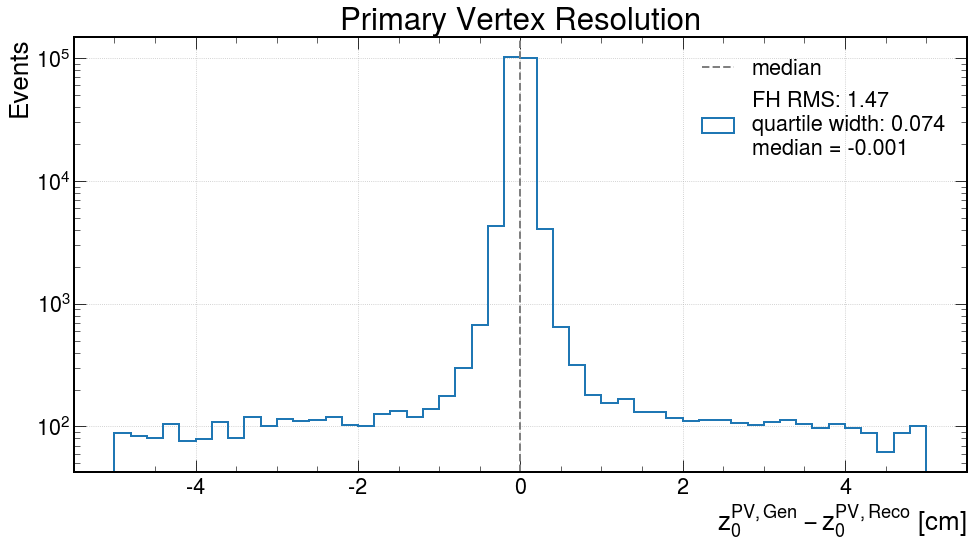

In [281]:
pm.pv_resolution(z0_gen=pm.z0_gen_cor, z0_reco=pm.z0_reco_fh)

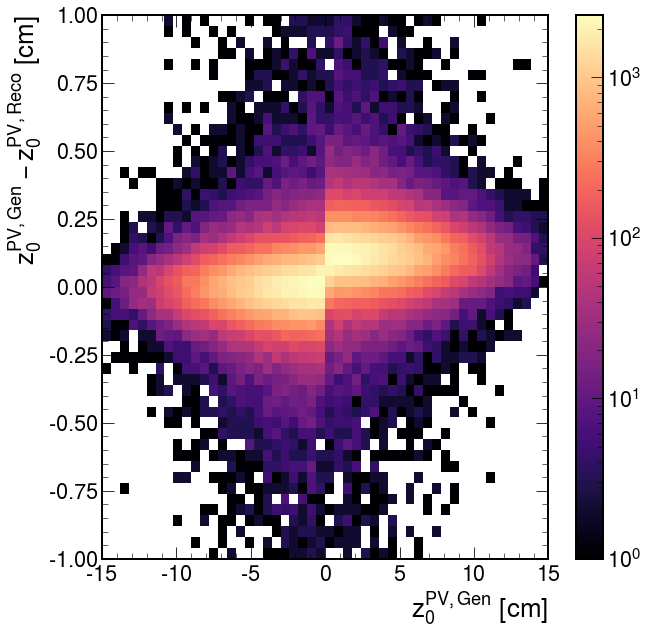

In [282]:
pm.res_vs_z0(pm.res_fh, pm.z0_gen, hrange=((-15, 15), (-1, 1)), dolog=True)

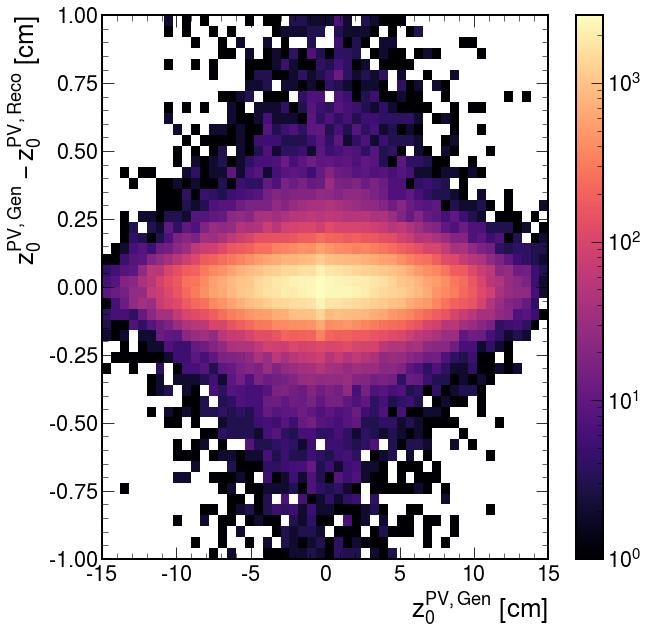

In [275]:
pm.res_vs_z0(
    res=(pm.z0_gen_cor - pm.z0_reco_fh),
    z0_gen=pm.z0_gen_cor,
    hrange=((-15, 15), (-1, 1)),
    dolog=True,
)

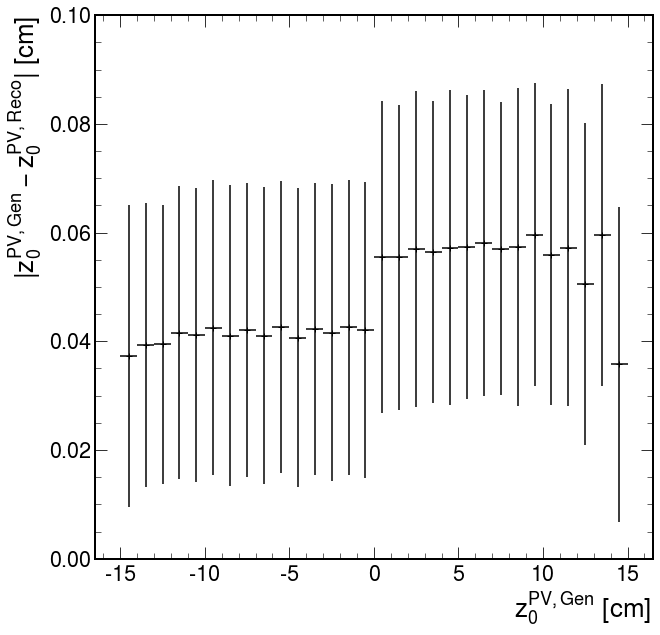

In [277]:
pm.plot_pv_resolution_z0(pm.z0_reco_fh)

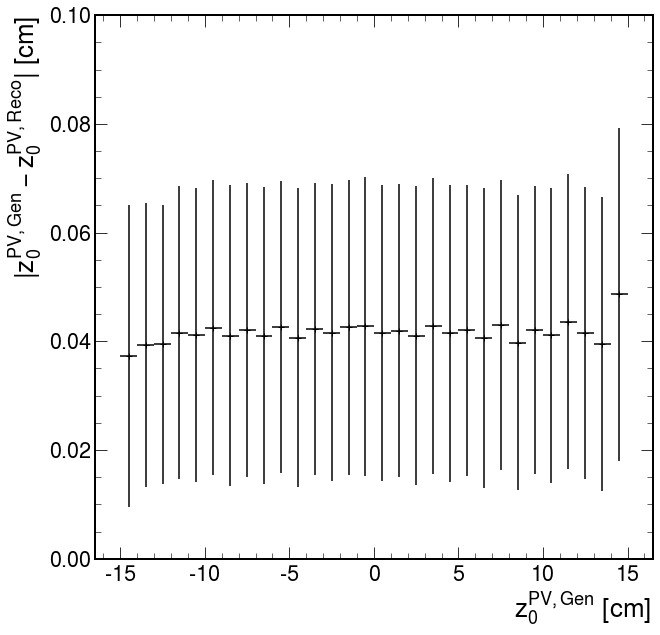

In [286]:
pm.plot_pv_resolution_z0(z0_gen=pm.z0_gen_cor, z0_reco=pm.z0_reco_fh)

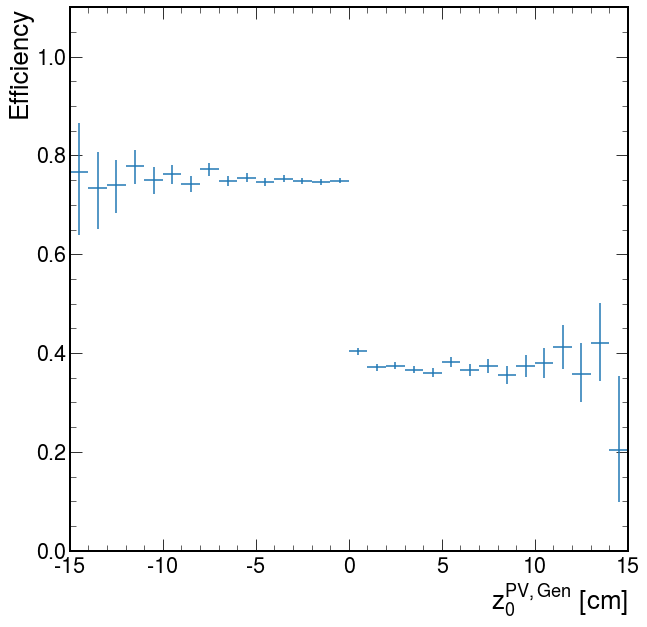

In [279]:
pm.plot_pv_efficiency_z0(pm.z0_gen, pm.z0_reco_fh)

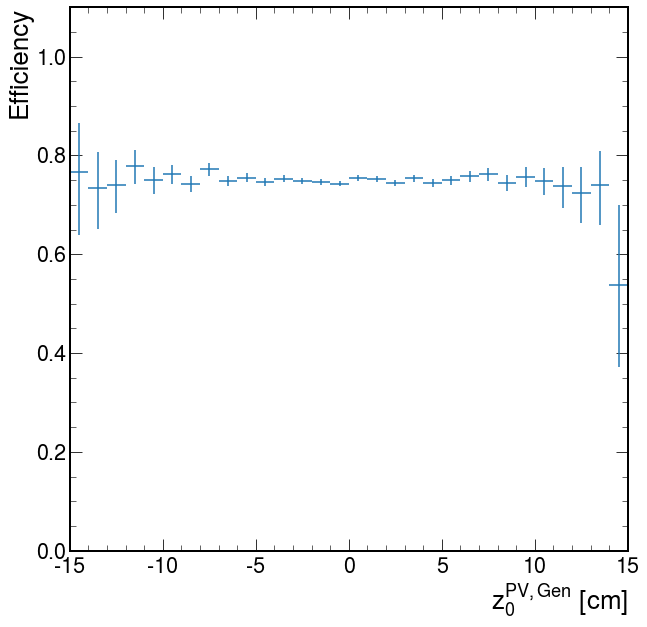

In [280]:
pm.plot_pv_efficiency_z0(z0_gen=pm.z0_gen_cor, z0_reco=pm.z0_reco_fh)

In [247]:
np.median(pm.z0_gen_cor)

-0.059837304

In [248]:
np.median(pm.z0_gen)

-0.00072641973

In [249]:
np.median(pm.z0_gen[pm.z0_gen > 0] - pm.z0_reco_fh[pm.z0_gen > 0])

0.118798494

In [252]:
np.median(pm.z0_gen[pm.z0_gen < 0] - pm.z0_reco_fh[pm.z0_gen < 0])

-0.0019552708

In [250]:
np.median(pm.z0_gen_cor[pm.z0_gen_cor > 0] - pm.z0_reco_fh[pm.z0_gen_cor > 0])

0.0011100769

In [251]:
np.median(pm.z0_gen_cor[pm.z0_gen_cor < 0] - pm.z0_reco_fh[pm.z0_gen_cor < 0])

-0.002947569

In [121]:
pv.fh_classification_metrics

{'tn': 29615833,
 'fp': 4968892,
 'fn': 454632,
 'tp': 5741283,
 'TPR': 0.9266239126908616,
 'FPR': 0.14367302327834036,
 'AUC': 0.8914754447062607}

In [122]:
accuracy_score(pv.trk["is_pv"], trk["trk_pv_assoc_fh"])

0.8670073838958878